# Bayesian Optimization

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import random
import tensorflow as tf
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")

2024-08-11 13:20:43.853547: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-11 13:20:43.853696: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-11 13:20:43.978969: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
labels = pd.read_csv("../input/g2net-gravitational-wave-detection/training_labels.csv")
display(labels.head())

,id,target
0,00000e74ad,1
1,00001f4945,0
2,0000661522,0
3,00007a006a,0
4,0000a38978,1


In [ ]:
! pip install optree
! pip install nnAudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.6 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.utils import Sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D, BatchNormalization
from keras.optimizers import RMSprop,Adam
import torch # For deep learning
from nnAudio.Spectrogram import CQT1992v2 # For creating Constant-Q Transform spectrograms
import math
from random import shuffle

import warnings
warnings.filterwarnings("ignore")

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, path, list_IDs, data, batch_size):
        self.path = path
        self.list_IDs = list_IDs
        self.data = data
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.list_IDs))

    def __len__(self):
        len_ = int(len(self.list_IDs)/self.batch_size)
        if len_*self.batch_size < len(self.list_IDs):
            len_ += 1
        return len_

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def __data_generation(self, list_IDs_temp):
        X = np.zeros((self.batch_size, 69, 193))
        y = np.zeros((self.batch_size, 1))
        for i, ID in enumerate(list_IDs_temp):
            id_ = self.data.loc[ID, 'id']
            file = id_+'.npy'
            path_in = '/'.join([self.path, id_[0], id_[1], id_[2]])+'/'
            data_array = np.load(path_in+file)
            #np.hstack() apiles arrays in a horizontal way
            waves = np.hstack(data_array)
            #normalize
            waves = waves / np.max(waves)
            #we do a pytorch tensor and convert it into float
            waves = torch.from_numpy(waves).float()
            transform=CQT1992v2(sr=2048, fmin=20, fmax=1024, hop_length=64, verbose = False)
            #Q-transform
            image = transform(waves)
            #We turn it back into a numpy array
            image = np.array(image)
            #transpose axes into (1,2,0)
            image = np.transpose(image,(1,2,0))
            # this creates an array(69, 193, 1) (an image in which the model can identify a signal)
            # and then we create a pack of images corresponding to the batch size
            # so the input_shape of the CNN must be (69, 193).
            X[i, ] = image[:,:,0]
            y[i, ] = self.data.loc[ID, 'target']
        X = np.stack(X)
        y = np.stack(y)
        return X, y

In [ ]:
import pandas as pd
import random
from itertools import cycle


#the train dataset is split in 16 files (0,1,2,...,e,f) and we will use all of this files separately
directorio = cycle(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f'])

In [ ]:
#this is the Bayesian Optimization library
!pip install scikit-optimize

In [ ]:
import skopt
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical

#we will study the logarithm of the number of neurons (base 2) and the number of dense layers
dim_log_width = Integer(low=4, high=8, name='log_width')
dim_layers = Integer(low=1, high=5, name='layers')
dimensions = [dim_log_width, dim_layers]

# The reason why I use numbers in between 2^4 and 2^8 in log_width is
# that the model becomes unstable for higher widths
# because each call only uses a small fragment of the dataset. Maybe if we used
# all the dataset for every call, we would obtain better results, but I don't
# have enough computational resources for that (it is too expensive).

In [ ]:
#These vectors just keep track of the width, layers studied in every step with its accuracy.
#I have used these values for a plot that shows how gp_minimize explores the hyperparameter space.
log_width_history = []
layers_history = []
acc_history = []


def train(params):
    #every call will use the next file
    directori = next(directorio)
    #This selects the file of the dataset
    train_idx = labels[labels['id'].str.startswith(directori)]['id'].values
    y = labels[labels['id'].isin(train_idx)]['target'].values
    #params is a vector with the dimensions (log_width, layers)
    print(params)
    log_width, layers = params
    log_width_history.append(log_width)
    layers_history.append(layers)

    #Generating the training and validation data
    train_idx, train_Valx = train_test_split(list(labels[labels['id'].str.startswith(directori)].index), test_size=0.2, random_state=2021)
    train_generator = DataGenerator('/kaggle/input/g2net-gravitational-wave-detection/train/', train_idx, labels[labels['id'].str.startswith(directori)], 256)
    val_generator = DataGenerator('/kaggle/input/g2net-gravitational-wave-detection/train/', train_Valx, labels[labels['id'].str.startswith(directori)], 256)

    # Building the model
    model = Sequential()
    model.add(Conv1D(2**log_width, input_shape=(69, 193,), kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Flatten())
    for i in range(layers):
        model.add(Dense(2**log_width, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=2e-4), loss='binary_crossentropy', metrics=['accuracy'])

    # Training the model
    history = model.fit(train_generator, validation_data=val_generator, epochs=1)

    # We evaluate the model's performance
    val_loss, val_accuracy = model.evaluate(val_generator)
    acc_history.append(val_accuracy)
    # It returns the metrics that we want to optimize with gp_minimize
    return -val_accuracy

In [ ]:
#Choosing our prior (the first set of hyperparameters studied)
default_parameters = [5, 1]

In [ ]:
# EI (expected improcvement) ACQ function is the safest in this context. However, PI (probability of improvement)
# can also be studied. It is a bit more agressive, but might work correctly as well.
# There are more options for ACQ functions but I am not sure if they will work
# Here we choose the number of times we want gp_minimize to call the training function.
# Every call it will study a set of hyperparameters, and it will not use an already used
# set of training data.
search_result = gp_minimize(
    func=train,
    dimensions=dimensions,
    acq_func='EI',
    n_calls=16,
    x0=default_parameters)

[5, 1]
  1/110 ━━━━━━━━━━━━━━━━━━━━ 1:21:39 45s/step - accuracy: 0.4531 - loss: 1.0656

I0000 00:00:1723382554.123792      82 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


110/110 ━━━━━━━━━━━━━━━━━━━━ 676s 6s/step - accuracy: 0.5114 - loss: 0.7437 - val_accuracy: 0.5100 - val_loss: 0.6892
28/28 ━━━━━━━━━━━━━━━━━━━━ 104s 4s/step - accuracy: 0.4940 - loss: 0.6896
[5, 5]
111/111 ━━━━━━━━━━━━━━━━━━━━ 666s 6s/step - accuracy: 0.5198 - loss: 0.6908 - val_accuracy: 0.6218 - val_loss: 0.6878
28/28 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - accuracy: 0.6327 - loss: 0.6874
[6, 1]
109/109 ━━━━━━━━━━━━━━━━━━━━ 668s 6s/step - accuracy: 0.5335 - loss: 0.7081 - val_accuracy: 0.5116 - val_loss: 0.6845
28/28 ━━━━━━━━━━━━━━━━━━━━ 101s 4s/step - accuracy: 0.5021 - loss: 0.6842
[6, 4]
110/110 ━━━━━━━━━━━━━━━━━━━━ 675s 6s/step - accuracy: 0.5290 - loss: 0.6886 - val_accuracy: 0.6639 - val_loss: 0.6811
28/28 ━━━━━━━━━━━━━━━━━━━━ 101s 4s/step - accuracy: 0.6623 - loss: 0.6814
[8, 2]
  1/109 ━━━━━━━━━━━━━━━━━━━━ 1:21:04 45s/step - accuracy: 0.4844 - loss: 0.7258

W0000 00:00:1723385720.762088      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


106/109 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.5261 - loss: 0.7378

W0000 00:00:1723386248.061883      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


109/109 ━━━━━━━━━━━━━━━━━━━━ 705s 6s/step - accuracy: 0.5280 - loss: 0.7356 - val_accuracy: 0.5844 - val_loss: 0.6808
28/28 ━━━━━━━━━━━━━━━━━━━━ 101s 4s/step - accuracy: 0.5692 - loss: 0.6816
[4, 4]
108/108 ━━━━━━━━━━━━━━━━━━━━ 696s 6s/step - accuracy: 0.4991 - loss: 0.6961 - val_accuracy: 0.4915 - val_loss: 0.6933
27/27 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - accuracy: 0.4974 - loss: 0.6932
[4, 5]
109/109 ━━━━━━━━━━━━━━━━━━━━ 712s 6s/step - accuracy: 0.5001 - loss: 0.6937 - val_accuracy: 0.4859 - val_loss: 0.6933
28/28 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.4937 - loss: 0.6932
[5, 3]
110/110 ━━━━━━━━━━━━━━━━━━━━ 724s 6s/step - accuracy: 0.5304 - loss: 0.6891 - val_accuracy: 0.5582 - val_loss: 0.6853
28/28 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.5507 - loss: 0.6848
[6, 5]
110/110 ━━━━━━━━━━━━━━━━━━━━ 727s 6s/step - accuracy: 0.5315 - loss: 0.6850 - val_accuracy: 0.6438 - val_loss: 0.6728
28/28 ━━━━━━━━━━━━━━━━━━━━ 101s 4s/step - accuracy: 0.6482 - loss: 0.6721
[8, 1]
  1/1

W0000 00:00:1723389886.683779      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


108/111 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - accuracy: 0.5083 - loss: 0.8806

W0000 00:00:1723390444.525970      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


111/111 ━━━━━━━━━━━━━━━━━━━━ 738s 6s/step - accuracy: 0.5098 - loss: 0.8751 - val_accuracy: 0.5300 - val_loss: 0.6860
28/28 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - accuracy: 0.5291 - loss: 0.6859
[5, 4]
110/110 ━━━━━━━━━━━━━━━━━━━━ 730s 6s/step - accuracy: 0.5128 - loss: 0.6920 - val_accuracy: 0.5310 - val_loss: 0.6881
28/28 ━━━━━━━━━━━━━━━━━━━━ 101s 4s/step - accuracy: 0.5176 - loss: 0.6886
[7, 5]
  1/109 ━━━━━━━━━━━━━━━━━━━━ 1:25:39 48s/step - accuracy: 0.4531 - loss: 0.6975

W0000 00:00:1723391597.149392      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


107/109 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.5349 - loss: 0.6825 

W0000 00:00:1723392137.908127      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


109/109 ━━━━━━━━━━━━━━━━━━━━ 723s 6s/step - accuracy: 0.5364 - loss: 0.6817 - val_accuracy: 0.5820 - val_loss: 0.6803
28/28 ━━━━━━━━━━━━━━━━━━━━ 101s 4s/step - accuracy: 0.5620 - loss: 0.6813
[6, 3]
110/110 ━━━━━━━━━━━━━━━━━━━━ 732s 6s/step - accuracy: 0.5380 - loss: 0.6848 - val_accuracy: 0.6642 - val_loss: 0.6781
28/28 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.6510 - loss: 0.6781
[7, 4]
  1/111 ━━━━━━━━━━━━━━━━━━━━ 1:22:58 45s/step - accuracy: 0.4688 - loss: 0.7173

W0000 00:00:1723393293.300654      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


109/111 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.5432 - loss: 0.6873 

W0000 00:00:1723393837.358927      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


111/111 ━━━━━━━━━━━━━━━━━━━━ 728s 6s/step - accuracy: 0.5444 - loss: 0.6866 - val_accuracy: 0.6787 - val_loss: 0.6754
28/28 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.6730 - loss: 0.6758
[7, 3]
  1/111 ━━━━━━━━━━━━━━━━━━━━ 1:14:00 40s/step - accuracy: 0.4688 - loss: 0.7220

W0000 00:00:1723394136.943459      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


109/111 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.5335 - loss: 0.6850 

W0000 00:00:1723394689.837342      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


111/111 ━━━━━━━━━━━━━━━━━━━━ 737s 6s/step - accuracy: 0.5351 - loss: 0.6840 - val_accuracy: 0.6865 - val_loss: 0.6703
28/28 ━━━━━━━━━━━━━━━━━━━━ 101s 4s/step - accuracy: 0.6886 - loss: 0.6705
[4, 3]
110/110 ━━━━━━━━━━━━━━━━━━━━ 738s 6s/step - accuracy: 0.5151 - loss: 0.6928 - val_accuracy: 0.5290 - val_loss: 0.6912
28/28 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.5240 - loss: 0.6914


In [ ]:
best_width = 2**(search_result.x[0])  # the best value of width obtained
best_layers = search_result.x[1]  # the best value of layers obtained
print(search_result.x)
for i in range(len(acc_history)):
    print(log_width_history[i], layers_history[i], acc_history[i])

[7, 3]
5 1 0.5100446343421936
5 5 0.6217913031578064
6 1 0.5115792155265808
6 4 0.6639229655265808
8 2 0.5844029188156128
4 4 0.49146410822868347
4 5 0.4859096109867096
5 3 0.5581752061843872
6 5 0.6438336968421936
8 1 0.5299944281578064
5 4 0.5309709906578064
7 5 0.58203125
6 3 0.6642020344734192
7 4 0.6787109375
7 3 0.6865234375
4 3 0.5290178656578064


In [ ]:
sample_submission = pd.read_csv('../input/g2net-gravitational-wave-detection/sample_submission.csv')
train_idx =  labels['id'].values
y = labels['target'].values
test_idx = sample_submission['id'].values
train_idx, train_Valx = train_test_split(list(labels.index), test_size=0.05, random_state=2021)
test_idx = list(sample_submission.index)

In [ ]:
train_generator = DataGenerator('/kaggle/input/g2net-gravitational-wave-detection/train/', train_idx, labels, 256)
val_generator = DataGenerator('/kaggle/input/g2net-gravitational-wave-detection/train/', train_Valx, labels, 256)
test_generator = DataGenerator('/kaggle/input/g2net-gravitational-wave-detection/test/', test_idx, sample_submission, 256)

In [ ]:
classical_model= Sequential()
classical_model.add(Conv1D(best_width, input_shape=(69, 193,), kernel_size=3, activation='relu'))
classical_model.add(BatchNormalization())
classical_model.add(Flatten())
for i in range(best_layers):
    classical_model.add(Dense(best_width, activation='relu'))
classical_model.add(Dense(1, activation='sigmoid'))
classical_model.compile(optimizer=Adam(learning_rate=2e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
classical_model.summary()
history_classical = classical_model.fit(train_generator, validation_data=val_generator, epochs = 1)
predict = classical_model.predict(test_generator, verbose=1)
sample_submission['target'] = predict[:len(sample_submission)]
sample_submission.to_csv('submission.csv', index=False)
my_submission = pd.read_csv("./submission.csv")
my_submission
import os
print(os.listdir("."))
print(os.listdir("/kaggle/working"))

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_16 (Conv1D)              │ (None, 67, 128)        │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 67, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 8576)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 128)            │     1,097,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,205,761 (4.60 MB)

 Trainable params: 1,205,505 (4.60 MB)

 Non-trainable params: 256 (1.00 KB)

   1/2079 ━━━━━━━━━━━━━━━━━━━━ 24:47:50 43s/step - accuracy: 0.5352 - loss: 0.6868

W0000 00:00:1723395855.524919      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2077/2079 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.7035 - loss: 0.5405

W0000 00:00:1723406718.810892      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2079/2079 ━━━━━━━━━━━━━━━━━━━━ 11480s 6s/step - accuracy: 0.7035 - loss: 0.5405 - val_accuracy: 0.7455 - val_loss: 0.4932
  1/883 ━━━━━━━━━━━━━━━━━━━━ 59:59 4s/step

W0000 00:00:1723407307.553591      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


883/883 ━━━━━━━━━━━━━━━━━━━━ 4762s 5s/step
['submission.csv', '__notebook__.ipynb']
['submission.csv', '__notebook__.ipynb']


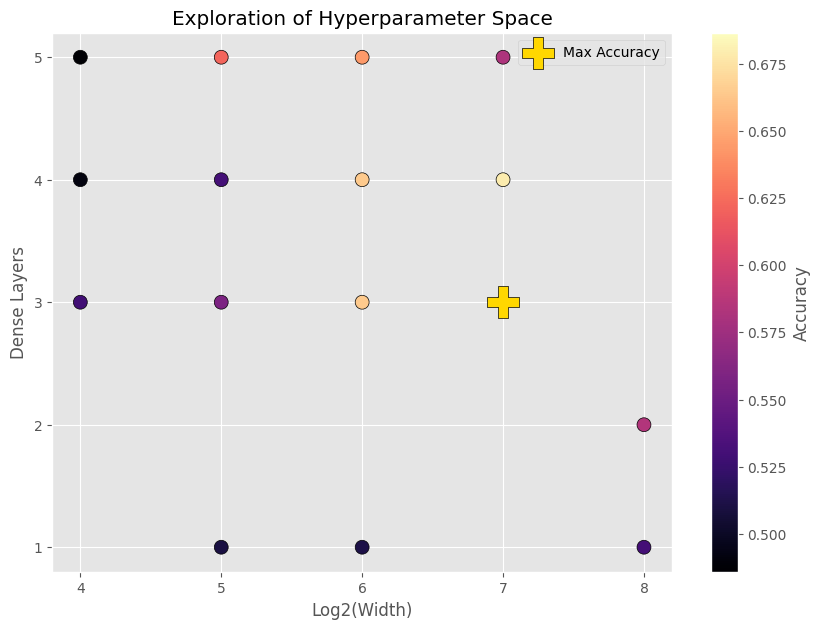

In [ ]:
# Convert lists to numpy arrays for easier manipulation
log_widths = np.array(log_width_history)
layers = np.array(layers_history)
accuracies = np.array(acc_history)

# Find the index of the best accuracy
best_index = np.argmax(accuracies)

# Create a scatter plot with a custom color map
plt.figure(figsize=(10, 7))
cmap = plt.get_cmap('magma')  # This color map provides a gradient from dark purple to pink
scatter = plt.scatter(log_widths, layers, c=accuracies, cmap=cmap, s=100, edgecolor='k')
plt.colorbar(scatter, label='Accuracy')
plt.xlabel('Log2(Width)')
plt.ylabel('Dense Layers')

# Mark the best configuration with a different symbol
plt.scatter(log_widths[best_index], layers[best_index], color='gold', s=500, marker='P', edgecolor='black', label='Max Accuracy')  # 'P' is a plus-filled marker

# Set x and y ticks to be integers
plt.xticks(np.arange(log_widths.min(), log_widths.max()+1, 1))
plt.yticks(np.arange(layers.min(), layers.max()+1, 1))

plt.legend()
plt.title('Exploration of Hyperparameter Space')
plt.grid(True)
plt.show()

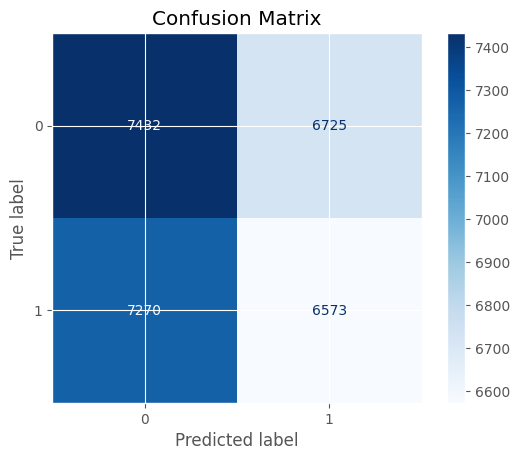

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Error-proofed Confusion Matrix
try:
    # Assuming predictions are already generated for the validation set
    y_true = labels.loc[val_generator.indexes, 'target']
    y_pred = (predict[:len(y_true)] > 0.5).astype(int)  # Ensure lengths match by slicing predict

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

except ValueError as e:
    print(f"Error creating confusion matrix: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

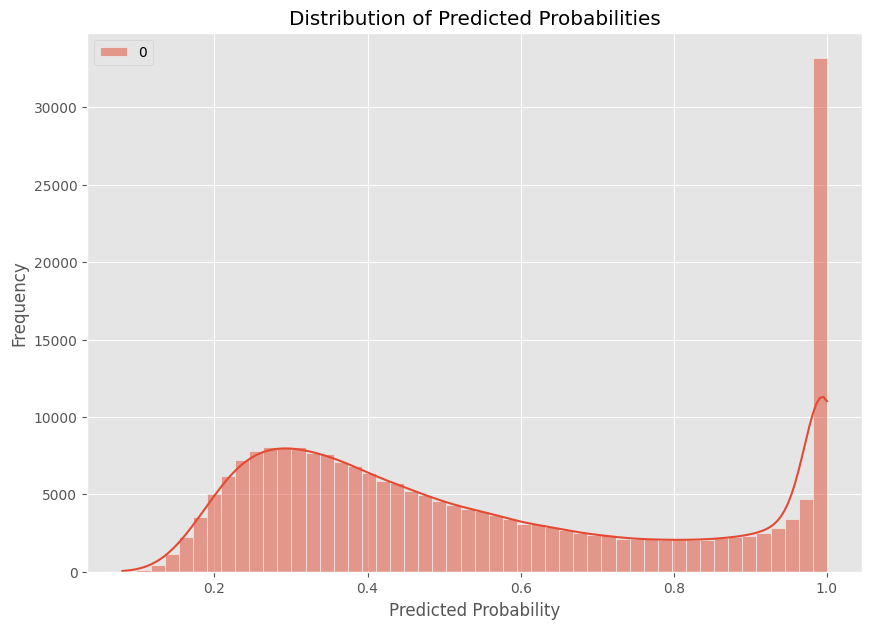

In [ ]:
from nnAudio.Spectrogram import CQT1992v2

# Error-proofed Distribution Plot
try:
    plt.figure(figsize=(10, 7))
    sns.histplot(predict, bins=50, kde=True)
    plt.title('Distribution of Predicted Probabilities')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"An error occurred while generating the distribution plot: {e}")
